In [11]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
import xrfdc #poorly documented library that handles interfacing to the RF data converter
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file
import pprint
pprint.pprint(ol.ip_dict)
dma = ol.axi_dma_0 #might need to change name depending on what you called it
rf = ol.usp_rf_data_converter_0 #might need to change name depending on what you called it
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

{'axi_dma_0': {'addr_range': 65536,
               'bdtype': None,
               'device': <pynq.pl_server.embedded_device.EmbeddedDevice object at 0xffff80640ca0>,
               'driver': <class 'pynq.lib.dma.DMA'>,
               'fullpath': 'axi_dma_0',
               'gpio': {},
               'interrupts': {},
               'mem_id': 'S_AXI_LITE',
               'memtype': 'REGISTER',
               'parameters': {'ADDR_WIDTH': '10',
                              'ARUSER_WIDTH': '0',
                              'AWUSER_WIDTH': '0',
                              'BUSER_WIDTH': '0',
                              'CLK_DOMAIN': 'design_1_zynq_ultra_ps_e_0_0_pl_clk0',
                              'C_BASEADDR': '0xA0000000',
                              'C_DLYTMR_RESOLUTION': '125',
                              'C_ENABLE_MULTI_CHANNEL': '0',
                              'C_FAMILY': 'zynquplus',
                              'C_HIGHADDR': '0xA000FFFF',
                          

                                                                                                     'pointer '
                                                                                                     'to '
                                                                                                     'the '
                                                                                                     'last '
                                                                                                     'descriptor '
                                                                                                     'it '
                                                                                                     'updated. \n'
                                                                                                     'Descriptors '
                                                                                                     'must '
  

                       'parameters': {'ADDR_WIDTH': '40',
                                      'ARUSER_WIDTH': '16',
                                      'AWUSER_WIDTH': '16',
                                      'BUSER_WIDTH': '0',
                                      'CAN0_BOARD_INTERFACE': 'custom',
                                      'CAN1_BOARD_INTERFACE': 'custom',
                                      'CLK_DOMAIN': 'design_1_zynq_ultra_ps_e_0_0_pl_clk0',
                                      'CSU_BOARD_INTERFACE': 'custom',
                                      'C_BASEADDR': '0x00000000',
                                      'C_DP_USE_AUDIO': '0',
                                      'C_DP_USE_VIDEO': '0',
                                      'C_EMIO_GPIO_WIDTH': '1',
                                      'C_EN_EMIO_TRACE': '0',
                                      'C_EN_FIFO_ENET0': '0',
                                      'C_EN_FIFO_ENET1': '0',
                   

In [12]:
adc_tile = rf.adc_tiles[2]
print(adc_tile)
adc_block = adc_tile.blocks[0]
print(adc_block)
print(adc_block.BlockStatus)
print(adc_block.MixerSettings)
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 96.9 #Target a radio station you found last week with this (MIT is 88.1... 96.9 is HOT, 100.7 is classic rock, etc...)
adc_block.MixerSettings['Freq']= center_frequency # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'SamplingFreq': 1.024, 'AnalogDataPathStatus': 1, 'DigitalDataPathStatus': 769, 'DataPathClocksStatus': 1, 'IsFIFOFlagsEnabled': 3, 'IsFIFOFlagsAsserted': 0}
{'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 16, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}
{'Freq': 96.89999999999782, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [10]:
# for just demod in hw
import numpy as np
import time
import struct
%matplotlib notebook
import matplotlib.pyplot as plt
from pynq import allocate
from scipy.signal import firwin
from IPython.display import Audio
# Sampling frequency
#fs = 147.456
fs = 0.25 #new for this week (250 ksps)
# Number of samples
#n = 262134 #new for this week (maybe)
n = 200000
#n = 65536
T = n/fs
down_from_center = center_frequency - fs/2
up_from_center = center_frequency + fs/2
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Allocate buffers for the input and output signals
ns = np.linspace(down_from_center, up_from_center,n,endpoint=False)
out_buffer = allocate(205000, dtype=np.uint32) #more than big enough to hold ~quarter million samples
# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma.recvchannel.transfer(out_buffer)
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware execution time: ',hw_exec_time)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

# real = np.array([twos_comp(out_buffer[i]&0xFFFF,16) for i in range(n)])
# imag = np.array([twos_comp(out_buffer[i]>>16,16) for i in range(n)])
real = np.zeros(n)
imag = np.zeros(n)
for i in range(n):
    imag[i],real[i] = struct.unpack(">hh",out_buffer[i])
# real,imag = struct.unpack("hh",out_buffer[[i]])
# real = np.array([struct.unpack("hh",out_buffer[i]&0xFFFF) for i in range(n)])
# imag = np.array([struct.unpack("hh",out_buffer[i]>>16) for i in range(n)])


out_buffer.close()
c_data = real + 1j*imag #make complex data
np.save("iq_15khz_high_amp.npy",c_data)
c_data = 0.5*np.angle(c_data) #demodulate
plot_data=c_data

#plt.plot(c_data[:1000000].real)
#plt.show()
taps = firwin(numtaps=101, cutoff=6.25e3, fs=250e3) #make another anti-alias filter for 20X decimation
c_data = np.convolve(c_data, taps, 'valid') #apply filter!
c_data=c_data[::20] #downsample to 12.5 ksps (factor of 20)
Audio(data=c_data.real, rate=12.5e3) #make audio signal at 12.5 ksps (use real component)

RuntimeError: DMA Internal Error (transfer length 0?)

<IPython.core.display.Javascript object>


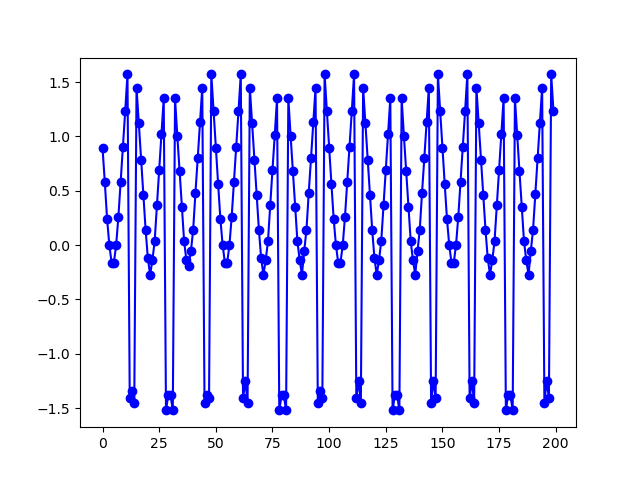

In [19]:
# plt.plot(real[2300:2400],"o-", color = "b")
# plt.plot(imag[2300:2400],"o-", color = "r")
plt.plot(plot_data.real[2300:2500],"o-", color = "b")

plt.show()

In [12]:
plt.plot(plot_data.real[2300:2500],"o-", color = "b")

plt.show()